In [1]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk


In [2]:
file_path = '/data/opinion_spam/real/reviewsNew.txt-utf8'
datas = []
MIN_FD = 100
raw_file = open(file_path)
debug = True
debug_size = 100
_debug_count = 0
for line in raw_file:    
    try:
        line = line.decode('gbk')
    except:
        continue
    #print 'gbk', line
    line = line.encode('utf-8')
    #print 'utf8', line
    item = line.split('\t')
    if len(item) == 8:
        hfd = float(item[3])
        fd = float(item[4])
        ratings = float(item[5])
        if fd > MIN_FD:
            hfdfd = round(hfd/fd, 2)
            #whole_filted_body += item[7]
            item.append(hfdfd)
            datas.append(item)
            if debug == True:
                _debug_count += 1
                if _debug_count >= debug_size:
                    break
raw_file.close()
print 'datas.size: ', len(datas)
print datas[0]

datas.size:  100
['A1004AX2J2HXGL', 'B00003CWPL', 'December 2, 2003', '111', '125', '5.0', '"But what the hell do they know, I said?"', ' If you\'re reading this, then you\'ve seen this movie or are at least curious what all the hype is about?    The late Stanley Kubrick, the only major filmmaker Lynch has cited as a direct cinematic influence, believed that ERASERHEAD was one of the most perfect "cinematic experiences" created to date.  This movie has enjoyed success on the midnight movie circuit for years, particularly in NYC where it ran almost every night for something like five years straight. I\'ve seen it on big and little screens in three different states.  Insofar as interpretations are concerned, I\'ve long since tossed all that out the window.  In terms of rational comprehension, ERASERHEAD is the fabled big fish that remains brilliantly elusive of any attempts to capture it.     This movie gets better, and more humorous, every time I watch it: in my opinion - ERASERHEAD is 

In [3]:
#set column names
column_names = ['rid', 'pid', 'date', 'hfd', 'fd', 'rating', 'title', 'body', 'hfdfd']
df = pd.DataFrame(datas)
df.columns = column_names
df.head()

,rid,pid,date,hfd,fd,rating,title,body,hfdfd
0,A1004AX2J2HXGL,B00003CWPL,"December 2, 2003",111,125,5.0,"""But what the hell do they know, I said?""","If you're reading this, then you've seen this...",0.89
1,A103PHKSEPT10R,0939484463,"July 5, 2000",69,116,5.0,"Credible, Interesting, & Devasting",I've read Prof Butz's book twice and an still...,0.59
2,A103U0Q3IKSXHE,0875845851,"January 29, 2000",111,115,4.0,Identifying the horns of the dilemma.,"Prior to reading this book, I chalked up the ...",0.97
3,A105YVLAZNYQUU,B000634DCW,"June 21, 2005",6,112,1.0,UGGHHH,Craptacular and boring. The cinematography an...,0.05
4,A1075MZNVRMSEO,1563249367,"April 2, 2002",190,190,5.0,A historical portrait & revelation- un chin de...,This book is a fascinating journey through th...,1.00


In [4]:
#transfer the type of column
df[['hfd', 'fd','rating']] = df[['hfd', 'fd', 'rating']].astype(float)

In [5]:
df.describe()

,hfd,fd,rating,hfdfd
count,100.000000,100.000000,100.00000,100.000000
mean,129.690000,159.060000,4.14000,0.801700
std,115.687291,118.980163,1.42148,0.261565
min,6.000000,101.000000,1.00000,0.050000
25%,92.750000,109.000000,4.00000,0.727500
50%,106.500000,124.500000,5.00000,0.930000
75%,137.000000,158.000000,5.00000,0.980000
max,966.000000,1065.000000,5.00000,1.000000


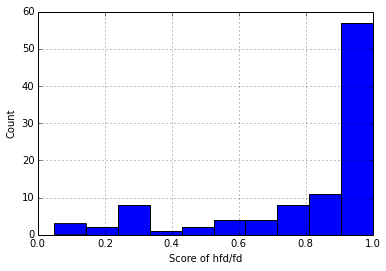

In [6]:
#hfdfd distribution
df.hfdfd.hist()
plt.title='The Distribute of hfd/fd'
plt.xlabel('Score of hfd/fd')
plt.ylabel('Count')

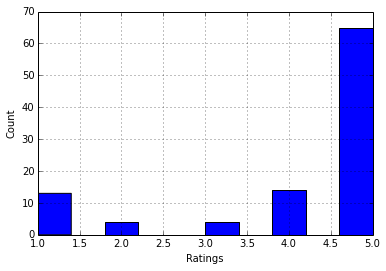

In [7]:
#rating distribution
df.rating.hist()
plt.xlabel('Ratings')
plt.ylabel("Count")

In [8]:
#count how many products in the dataset  ==》9809 products
df.groupby('pid').count().shape
print 'different product size:', df.groupby('pid').count().shape[0] 

different product size: 100


In [9]:
df.shape

(100, 9)

In [10]:
df['title_len'] = df['title'].apply(len)
df['body_len'] = df['body'].apply(len)

In [11]:
df.head()

,rid,pid,date,hfd,fd,rating,title,body,hfdfd,title_len,body_len
0,A1004AX2J2HXGL,B00003CWPL,"December 2, 2003",111,125,5,"""But what the hell do they know, I said?""","If you're reading this, then you've seen this...",0.89,41,2642
1,A103PHKSEPT10R,0939484463,"July 5, 2000",69,116,5,"Credible, Interesting, & Devasting",I've read Prof Butz's book twice and an still...,0.59,34,313
2,A103U0Q3IKSXHE,0875845851,"January 29, 2000",111,115,4,Identifying the horns of the dilemma.,"Prior to reading this book, I chalked up the ...",0.97,37,1495
3,A105YVLAZNYQUU,B000634DCW,"June 21, 2005",6,112,1,UGGHHH,Craptacular and boring. The cinematography an...,0.05,6,1045
4,A1075MZNVRMSEO,1563249367,"April 2, 2002",190,190,5,A historical portrait & revelation- un chin de...,This book is a fascinating journey through th...,1.00,59,2180


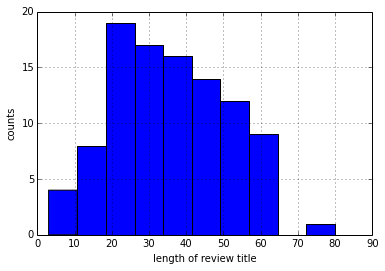

In [12]:
df['title_len'].hist()
plt.xlabel('length of review title')
plt.ylabel('counts')

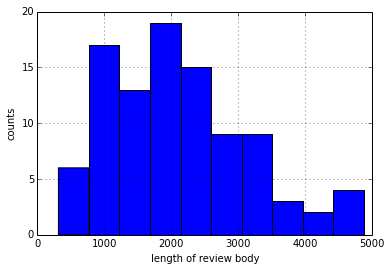

In [13]:
df[df['body_len'] > 10][df['body_len'] < 5000]['body_len'].hist()
plt.xlim(0, 5000)
plt.xlabel("length of review body")
plt.ylabel("counts")

In [14]:
df[['title_len', 'body_len']].describe()

,title_len,body_len
count,100.000000,100.000000
mean,35.810000,2190.390000
std,15.042495,1157.861036
min,3.000000,313.000000
25%,24.000000,1342.500000
50%,35.000000,2024.000000
75%,48.000000,2882.000000
max,80.000000,5397.000000


# TFIDF features

In [15]:
#TFIDF feature without lsa

import evaluation_self as es
max_features_count = 10000
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.5, max_features=max_features_count,
                                 min_df=2, stop_words='english', tokenizer = es.tokenize_and_stem)

tfidf_matrix = vectorizer.fit_transform(df.body)
print "the tfidf matrix size : ",tfidf_matrix.shape
print type(tfidf_matrix)


the tfidf matrix size :  (100, 1856)
<class 'scipy.sparse.csr.csr_matrix'>


In [16]:
#TFIDF-CV-10-lsvr
from sklearn.svm import LinearSVR

lsvr = LinearSVR()

from sklearn.cross_validation import cross_val_score

scores2 = cross_val_score(lsvr, tfidf_matrix, df.hfdfd, cv=10, scoring="mean_squared_error")

mse2 = abs(scores2)
print 'TFIDF-cv10-LSVR, mse:', mse2
print 'TFIDF-cv10-LSVR, mse mean:', np.mean(mse2)
print 'TFIDF-cv10-LSVR, rmse:', np.sqrt(mse2)
print 'TFIDF-cv10-LSVR, rmse mean:', np.mean(np.sqrt(mse2))

TFIDF-cv10-LSVR, mse: [ 0.08141925  0.04912799  0.10494847  0.04176103  0.06310264  0.04258743
  0.0500274   0.03956934  0.01890513  0.07190517]
TFIDF-cv10-LSVR, mse mean: 0.0563353850276
TFIDF-cv10-LSVR, rmse: [ 0.28534059  0.22164834  0.32395751  0.20435515  0.25120238  0.20636721
  0.22366807  0.19892043  0.13749594  0.2681514 ]
TFIDF-cv10-LSVR, rmse mean: 0.232110703073


In [17]:
#TFIDF-CV-10-svr
from sklearn.svm import SVR

svr = SVR()

from sklearn.cross_validation import cross_val_score

scores2 = cross_val_score(svr, tfidf_matrix, df.hfdfd, cv=10, scoring="mean_squared_error")

mse2 = abs(scores2)
print 'TFIDF-cv10-SVR, mse:', mse2
print 'TFIDF-cv10-SVR, mse mean:', np.mean(mse2)
print 'TFIDF-cv10-SVR, rmse:', np.sqrt(mse2)
print 'TFIDF-cv10-SVR, rmse mean:', np.mean(np.sqrt(mse2))

TFIDF-cv10-SVR, mse: [ 0.10782484  0.03885816  0.15268398  0.01068192  0.0971278   0.07590734
  0.07890349  0.05963978  0.00829349  0.10984222]
TFIDF-cv10-SVR, mse mean: 0.0739763006971
TFIDF-cv10-SVR, rmse: [ 0.32836693  0.19712472  0.39074797  0.10335338  0.31165334  0.27551286
  0.28089765  0.24421256  0.09106859  0.33142453]
TFIDF-cv10-SVR, rmse mean: 0.255436253884


In [18]:
#TFIDF-CV-10-lr
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

from sklearn.cross_validation import cross_val_score

scores2 = cross_val_score(lr, tfidf_matrix, df.hfdfd, cv=10, scoring="mean_squared_error")

mse2 = abs(scores2)
print 'TFIDF-cv10-LR, mse:', mse2
print 'TFIDF-cv10-LR, mse mean:', np.mean(mse2)
print 'TFIDF-cv10-LR, rmse:', np.sqrt(mse2)
print 'TFIDF-cv10-LR, rmse mean:', np.mean(np.sqrt(mse2))

TFIDF-cv10-LR, mse: [ 0.08428988  0.04914983  0.10853811  0.03688545  0.06363214  0.04363286
  0.05190089  0.0389887   0.01494012  0.07207759]
TFIDF-cv10-LR, mse mean: 0.0564035564685
TFIDF-cv10-LR, rmse: [ 0.29032719  0.22169761  0.32945123  0.19205586  0.25225411  0.2088848
  0.22781766  0.19745556  0.12222977  0.2684727 ]
TFIDF-cv10-LR, rmse mean: 0.231064649804


# TFIDF - LSA features

In [19]:
#TFIDF feature without lsa
from time import time
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

import evaluation_self as es
max_features_count = 10000
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.5, max_features=max_features_count,
                                 min_df=2, stop_words='english', tokenizer = es.tokenize_and_stem)
lsa_tfidf_matrix = vectorizer.fit_transform(df.body)
print "the tfidf matrix size : ",tfidf_matrix.shape
print type(tfidf_matrix)

lsaornot = True
lsanum = 1000

if lsaornot:
    print "Performing dimensionality reduction using LSA"
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(lsanum)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    lsa_tfidf_matrix = lsa.fit_transform(tfidf_matrix)

    print "done in ", (time() - t0)
    explained_variance = svd.explained_variance_ratio_.sum()
    print "Explained variance of the SVD step:", int(explained_variance * 100)


the tfidf matrix size :  (100, 1856)
<class 'scipy.sparse.csr.csr_matrix'>
Performing dimensionality reduction using LSA
done in  4.06745004654
Explained variance of the SVD step: 100


In [20]:
#TFIDF-LSA-cv10-LR
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

from sklearn.cross_validation import cross_val_score

scores2 = cross_val_score(lr, lsa_tfidf_matrix, df.hfdfd, cv=10, scoring="mean_squared_error")

mse2 = abs(scores2)
print 'TFIDF-LSA-cv10-LR, mse:', mse2
print 'TFIDF-LSA-cv10-LR, mse mean:', np.mean(mse2)
print 'TFIDF-LSA-cv10-LR, rmse2:', np.sqrt(mse2)
print 'TFIDF-LSA-cv10-LR, rmse2 mean:', np.mean(np.sqrt(mse2))

TFIDF-LSA-cv10-LR, mse: [ 0.08006862  0.04964595  0.10925664  0.03678711  0.10221044  0.03274556
  0.05157836  0.07870043  0.01658272  0.10811737]
TFIDF-LSA-cv10-LR, mse mean: 0.0665693193636
TFIDF-LSA-cv10-LR, rmse2: [ 0.282964    0.2228137   0.33053992  0.19179967  0.31970367  0.18095735
  0.2271087   0.28053597  0.12877389  0.32881206]
TFIDF-LSA-cv10-LR, rmse2 mean: 0.249400892182


In [21]:
#TFIDF-LSA-CV-10-lsvr
from sklearn.svm import LinearSVR

lsvr = LinearSVR()

from sklearn.cross_validation import cross_val_score

scores2 = cross_val_score(lsvr, lsa_tfidf_matrix, df.hfdfd, cv=10, scoring="mean_squared_error")

mse2 = abs(scores2)
print 'TFIDF-cv10-LSVR, mse:', mse2
print 'TFIDF-cv10-LSVR, mse mean:', np.mean(mse2)
print 'TFIDF-cv10-LSVR, rmse:', np.sqrt(mse2)
print 'TFIDF-cv10-LSVR, rmse mean:', np.mean(np.sqrt(mse2))

TFIDF-cv10-LSVR, mse: [ 0.08141942  0.0491236   0.10494618  0.04175843  0.0631031   0.04258581
  0.05002453  0.03957113  0.01890863  0.07190426]
TFIDF-cv10-LSVR, mse mean: 0.0563345091237
TFIDF-cv10-LSVR, rmse: [ 0.28534089  0.22163843  0.32395398  0.20434881  0.2512033   0.20636329
  0.22366164  0.19892494  0.13750865  0.2681497 ]
TFIDF-cv10-LSVR, rmse mean: 0.232109363337


In [22]:
#TFIDF-LSA-CV-10-svr
t0 = time()
from sklearn.svm import SVR

svr = SVR()

from sklearn.cross_validation import cross_val_score

scores2 = cross_val_score(svr, lsa_tfidf_matrix, df.hfdfd, cv=10, scoring="mean_squared_error")

mse2 = abs(scores2)
print 'TFIDF-cv10-SVR, mse:', mse2
print 'TFIDF-cv10-SVR, mse mean:', np.mean(mse2)
print 'TFIDF-cv10-SVR, rmse:', np.sqrt(mse2)
print 'TFIDF-cv10-SVR, rmse mean:', np.mean(np.sqrt(mse2))
print "tfidf-svr cost:", (time() - t0)

TFIDF-cv10-SVR, mse: [ 0.10253726  0.03873028  0.14433088  0.01243679  0.09113803  0.07184335
  0.07314219  0.0558068   0.00898287  0.1030408 ]
TFIDF-cv10-SVR, mse mean: 0.0701989240622
TFIDF-cv10-SVR, rmse: [ 0.3202144   0.1968001   0.37990904  0.11152036  0.30189076  0.26803609
  0.27044813  0.23623462  0.094778    0.32099969]
TFIDF-cv10-SVR, rmse mean: 0.250083118278
tfidf-svr cost: 0.0429480075836


# STD features

In [23]:
#STD features

import nltk
import re

def seg_sentence(text):
    sentences = nltk.sent_tokenize(text)
    return [s.strip() for s in sentences if(len(s)) > 0]

def marks_num(text, pattern):
    return len(re.findall(pattern, text))

std_exc = 0
def std(text): # std in Yang@acl-2015
#    print '==============================='
    ary = [0, 0, 0, 0, 0]
    try:
        tokens = es.tokenize_and_stem(text)
        token_num = len(tokens)
    #    print 'token size:', token_num
        sentences = seg_sentence(text)
        sen_num = len(sentences)
    #    print 'sentence size:', sen_num
        avg_sentence_len = np.mean([len(x) for x in sentences])
    #    print 'avg sentence length:', avg_sentence_len
        exc_num = marks_num(text, r'[!！]')
    #    print 'exclamation marks count:', exc_num
        que_num = marks_num(text, r'[？?]')
    #    print 'question percentage:', float(que_num) / sen_num
        ary = [token_num, sen_num, avg_sentence_len, exc_num, que_num]
#         print ary
    except:
#         print text
        std_exc += 1
    finally:
        return ary
    
for loc in range(1, 10):
    print std(df.body.head(10)[loc])

[46, 3, 100.33333333333333, 0, 0]
[152, 12, 122.08333333333333, 0, 0]
[118, 12, 85.333333333333329, 0, 3]
[173, 11, 196.36363636363637, 1, 0]
[122, 15, 77.933333333333337, 1, 1]
[255, 21, 134.38095238095238, 0, 1]
[47, 3, 101.0, 1, 0]
[110, 6, 155.16666666666666, 0, 0]
[151, 13, 117.84615384615384, 0, 2]


In [24]:
#generate std features


std_x = np.array(df.body)
print type(std_x)
std_x = np.array(map(std, std_x))
print "std exception: ", std_exc

print type(std_x)
print std_x.shape

from sklearn.preprocessing import Normalizer
std_normalizer = Normalizer().fit(std_x)
std_x = std_normalizer.transform(std_x)


<type 'numpy.ndarray'>
std exception:  0
<type 'numpy.ndarray'>
(100, 5)


In [25]:
#std-cv10-lr
from sklearn.linear_model import LinearRegression
std_lr = LinearRegression()

std_scores = cross_val_score(std_lr, std_x, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'STD-cv10-LR, mse:', std_mse
print 'STD-cv10-LR, mse mean:', np.mean(std_mse)
print 'STD-cv10-LR, rmse:', np.sqrt(std_mse)
print 'STD-cv10-LR, rmse mean:', np.mean(np.sqrt(std_mse))

STD-cv10-LR, mse: [ 0.06500286  0.03528658  0.1532927   0.01377453  0.08483742  0.04885342
  0.07232473  0.04269288  0.02168829  0.0902642 ]
STD-cv10-LR, mse mean: 0.0628017604365
STD-cv10-LR, rmse: [ 0.25495658  0.18784721  0.39152611  0.11736496  0.29126863  0.22102809
  0.26893258  0.20662256  0.14726944  0.30044002]
STD-cv10-LR, rmse mean: 0.238725618604


In [26]:
#std-cv10-lsvr
from sklearn.svm import LinearSVR
std_lsvr = LinearSVR()

std_scores = cross_val_score(std_lsvr, std_x, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'STD-cv10-LSVR, mse:', std_mse
print 'STD-cv10-LSVR, mse mean:', np.mean(std_mse)
print 'STD-cv10-LSVR, rmse:', np.sqrt(std_mse)
print 'STD-cv10-LSVR, rmse mean:', np.mean(np.sqrt(std_mse))

STD-cv10-LSVR, mse: [ 0.11377503  0.03723815  0.17545945  0.00339732  0.11292987  0.08042356
  0.09290938  0.05865561  0.00655683  0.12968777]
STD-cv10-LSVR, mse mean: 0.0811032975455
STD-cv10-LSVR, rmse: [ 0.33730554  0.19297188  0.41887881  0.05828654  0.3360504   0.28359048
  0.30481039  0.24218921  0.08097424  0.36012189]
STD-cv10-LSVR, rmse mean: 0.261517938491


In [27]:
#std-cv10-svr
t0 = time()
from sklearn.svm import SVR
std_svr = SVR()

std_scores = cross_val_score(std_svr, std_x, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'STD-cv10-SVR, mse:', std_mse
print 'STD-cv10-SVR, mse mean:', np.mean(std_mse)
print 'STD-cv10-SVR, rmse:', np.sqrt(std_mse)
print 'STD-cv10-SVR, rmse mean:', np.mean(np.sqrt(std_mse))
print "STD-svr cost:", (time() - t0)

STD-cv10-SVR, mse: [ 0.10395625  0.03702948  0.15147344  0.01011492  0.09645771  0.0735336
  0.07717419  0.0560485   0.01123691  0.11054614]
STD-cv10-SVR, mse mean: 0.0727571150049
STD-cv10-SVR, rmse: [ 0.32242247  0.19243046  0.38919589  0.10057296  0.31057642  0.27117079
  0.27780244  0.23674563  0.10600431  0.3324848 ]
STD-cv10-SVR, rmse mean: 0.253940618231
STD-svr cost: 0.0290849208832


In [28]:
#def cut sentence
stop_words = 'a,able,about,across,after,all,almost,also,am,among,an,and,any,are,as,at,be,because,been,but,by,can,cannot,could,dear,did,do,does,either,else,ever,every,for,from,get,got,had,has,have,he,her,hers,him,his,how,however,i,if,in,into,is,it,its,just,least,let,like,likely,may,me,might,most,must,my,neither,no,nor,not,of,off,often,on,only,or,other,our,own,rather,said,say,says,she,should,since,so,some,than,that,the,their,them,then,there,these,they,this,tis,to,too,twas,us,wants,was,we,were,what,when,where,which,while,who,whom,why,will,with,would,yet,you,your'
stop_words_list = stop_words.split(',')

def cut_into_tokens(text):

    _list = [word.lower() for sentence in nltk.sent_tokenize(text) for word in sentence.split()]
    _list = [re.sub(r'[.?!\'",)(;&%:]', '', word) for word in _list  ]
    _list = [word for word in _list if word not in stop_words_list and len(word) > 0]
    return _list

# Syntactic features of Kim

In [29]:
#Syntactic features of Kim

text = df.body.head(1)[0]
print text
#print nltk.pos_tag([word  for sentence in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sentence)])

def pos_count(text):
    poses = nltk.pos_tag(cut_into_tokens(text))
#     poses = nltk.pos_tag([word  for sentence in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sentence)])
    pos_dict = {}
    for (word, pos) in poses:
        if pos in pos_dict:
            pos_dict[pos] = pos_dict[pos] + 1
        else:
            pos_dict[pos] = 1
    return pos_dict

pos_dict = pos_count(text)#per sentence per second!!!!
# for pos in pos_dict:
#     print pos, " => ", pos_dict[pos]
# print 'aa'
syn_exc = 0

def fetch_count_from_pos_dict(pos_list, pos_dict):
    _pos_count = 0
    for pos in pos_list:
        if pos in pos_dict:
            _pos_count += pos_dict[pos]
    return _pos_count

def syntactic_feature(text): #syn feature function
    ary = [0, 0, 0, 0]
    try:
        pos_dict = pos_count(text)
        nn_count = fetch_count_from_pos_dict(['NN', 'NNS', 'NNP', 'NNPS'], pos_dict)#noun
        jj_count = fetch_count_from_pos_dict(['JJ', 'JJR', 'JJS'], pos_dict)#adj
        vb_count = fetch_count_from_pos_dict(['VB', 'VBD', 'VBG', 'VBN', 'VNP', 'VBZ'], pos_dict)#vb
        rb_count = fetch_count_from_pos_dict(['RB', 'RBR', 'RBS'], pos_dict)#adv
        ary = [nn_count, jj_count, vb_count, rb_count]
    except:
        print 'error'
        syn_exc += 1
    finally:
        return ary
# print 't_dict', pos_dict['_t_dict']
for _text in df.body.head(10):
    print syntactic_feature(_text)
print 'syn_exc is ', syn_exc

 If you're reading this, then you've seen this movie or are at least curious what all the hype is about?    The late Stanley Kubrick, the only major filmmaker Lynch has cited as a direct cinematic influence, believed that ERASERHEAD was one of the most perfect "cinematic experiences" created to date.  This movie has enjoyed success on the midnight movie circuit for years, particularly in NYC where it ran almost every night for something like five years straight. I've seen it on big and little screens in three different states.  Insofar as interpretations are concerned, I've long since tossed all that out the window.  In terms of rational comprehension, ERASERHEAD is the fabled big fish that remains brilliantly elusive of any attempts to capture it.     This movie gets better, and more humorous, every time I watch it: in my opinion - ERASERHEAD is the cinematic experience that comes the closest to capturing "dream logic", next to the equally brilliant WAKING LIFE.  If you ever get the c

In [30]:
X_syn = []
for _body in df.body:
    _v = syntactic_feature(_body)
    X_syn.append(_v)
print len(X_syn)

from sklearn.preprocessing import Normalizer

syn_normalizer = Normalizer()
syn_normalizer.fit(X_syn)
X_syn = syn_normalizer.transform(X_syn)

# print X_w2v
print syn_normalizer

100
Normalizer(copy=True, norm='l2')


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


In [31]:
#syn-cv-10-LR
from sklearn.linear_model import LinearRegression

syn_lr = LinearRegression()

std_scores = cross_val_score(syn_lr, X_syn, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'SYN-cv10-LR, mse:', std_mse
print 'SYN-cv10-LR, mse mean:', np.mean(std_mse)
print 'SYN-cv10-LR, rmse:', np.sqrt(std_mse)
print 'SYN-cv10-LR, rmse mean:', np.mean(np.sqrt(std_mse))

SYN-cv10-LR, mse: [ 0.10462254  0.05454791  0.13415301  0.03058137  0.11306078  0.08782886
  0.05758035  0.0522465   0.01209688  0.07854349]
SYN-cv10-LR, mse mean: 0.0725261692847
SYN-cv10-LR, rmse: [ 0.32345407  0.23355494  0.36626905  0.1748753   0.33624512  0.29635935
  0.23995905  0.22857494  0.1099858   0.28025611]
SYN-cv10-LR, rmse mean: 0.258953373802


In [32]:
#syn-cv-10-LSVR
from sklearn.svm import LinearSVR

syn_lsvr = LinearSVR()

std_scores = cross_val_score(syn_lsvr, X_syn, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'SYN-cv10-LSVR, mse:', std_mse
print 'SYN-cv10-LSVR, mse mean:', np.mean(std_mse)
print 'SYN-cv10-LSVR, rmse:', np.sqrt(std_mse)
print 'SYN-cv10-LSVR, rmse mean:', np.mean(np.sqrt(std_mse))

SYN-cv10-LSVR, mse: [ 0.13102097  0.046614    0.17911154  0.00585943  0.11172521  0.09141683
  0.09245582  0.05799587  0.00256428  0.12499173]
SYN-cv10-LSVR, mse mean: 0.0843755699511
SYN-cv10-LSVR, rmse: [ 0.36196818  0.21590277  0.42321572  0.07654695  0.33425322  0.30235217
  0.30406548  0.24082331  0.05063877  0.3535417 ]
SYN-cv10-LSVR, rmse mean: 0.266330826192


In [33]:
#syn-cv-10-SVR
t0 = time()
from sklearn.svm import SVR

syn_lsvr = SVR()

std_scores = cross_val_score(syn_lsvr, X_syn, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'SYN-cv10-SVR, mse:', std_mse
print 'SYN-cv10-SVR, mse mean:', np.mean(std_mse)
print 'SYN-cv10-SVR, rmse:', np.sqrt(std_mse)
print 'SYN-cv10-SVR, rmse mean:', np.mean(np.sqrt(std_mse))
print "SYN-svr cost:", (time() - t0)

SYN-cv10-SVR, mse: [ 0.10835548  0.04106706  0.15071772  0.0124428   0.09822887  0.0789925
  0.07749351  0.05689127  0.00612068  0.10719769]
SYN-cv10-SVR, mse mean: 0.0737507600257
SYN-cv10-SVR, rmse: [ 0.32917394  0.20265009  0.38822381  0.11154731  0.31341485  0.28105605
  0.27837656  0.23851892  0.07823481  0.32741059]
SYN-cv10-SVR, rmse mean: 0.254860691454
SYN-svr cost: 0.0341169834137


# Word2Vec features

In [34]:
#w2v features

from gensim import corpora, models, similarities
import gensim

#load model
fname = '/data/opinion_spam/real/w2v-hfd-over-0.total'
#gensim.models.Word2Vec(sentences, min_count=5, size=100, window=5, workers=32)
model = gensim.models.Word2Vec.load(fname)
model.init_sims(replace=True)

In [35]:
def model_with_sentence(sentence, model):
    tokens = cut_into_tokens(sentence)
    v = np.zeros(100)
    _error = 0
    for token in tokens:
        try:
            _v = model[token]
            v += _v
        except:
            _error += 1
#             print 'token:', token, 'not in the dict'
    return v
print 'def model_with_sentence'

def model_with_sentence


In [36]:
X_w2v = []
for _body in df.body:
    _v = model_with_sentence(_body, model)
    X_w2v.append(_v)
print len(X_w2v)

from sklearn.preprocessing import Normalizer

w2v_normalizer = Normalizer()
w2v_normalizer.fit(X_w2v)
X_w2v = w2v_normalizer.transform(X_w2v)

# print X_w2v
print w2v_normalizer

100
Normalizer(copy=True, norm='l2')


In [37]:
#w2v-cv-10-LR
from sklearn.linear_model import LinearRegression

w2v_lr = LinearRegression()

std_scores = cross_val_score(w2v_lr, X_w2v, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'W2V-cv10-LR, mse:', std_mse
print 'W2V-cv10-LR, mse mean:', np.mean(std_mse)
print 'W2V-cv10-LR, rmse:', np.sqrt(std_mse)
print 'W2V-cv10-LR, rmse mean:', np.mean(np.sqrt(std_mse))

W2V-cv10-LR, mse: [ 0.23995108  0.4017458   0.90328586  0.33569364  0.39553965  0.31661745
  0.39600169  0.3550751   0.14575424  0.32750875]
W2V-cv10-LR, mse mean: 0.381717325347
W2V-cv10-LR, rmse: [ 0.48984801  0.6338342   0.95041352  0.57939075  0.62891943  0.5626877
  0.62928665  0.59588179  0.38177774  0.5722838 ]
W2V-cv10-LR, rmse mean: 0.602432359351


In [38]:
#w2v-cv-10-LSVR
from sklearn.svm import LinearSVR

w2v_lsvr = LinearSVR()

std_scores = cross_val_score(w2v_lsvr, X_w2v, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'W2V-cv10-LSVR, mse:', std_mse
print 'W2V-cv10-LSVR, mse mean:', np.mean(std_mse)
print 'W2V-cv10-LSVR, rmse:', np.sqrt(std_mse)
print 'W2V-cv10-LSVR, rmse mean:', np.mean(np.sqrt(std_mse))

W2V-cv10-LSVR, mse: [ 0.03931486  0.03252135  0.09752162  0.02300118  0.03382264  0.03624022
  0.05279269  0.03912735  0.01959384  0.09781817]
W2V-cv10-LSVR, mse mean: 0.0471753910219
W2V-cv10-LSVR, rmse: [ 0.19827976  0.18033678  0.31228451  0.15166139  0.18390933  0.19036863
  0.22976659  0.19780635  0.13997798  0.31275896]
W2V-cv10-LSVR, rmse mean: 0.209715028807


In [39]:
#w2v-cv-10-SVR
t0 = time()
from sklearn.svm import SVR

w2v_svr = SVR()

std_scores = cross_val_score(w2v_svr, X_w2v, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'W2V-cv10-SVR, mse:', std_mse
print 'W2V-cv10-SVR, mse mean:', np.mean(std_mse)
print 'W2V-cv10-SVR, rmse:', np.sqrt(std_mse)
print 'W2V-cv10-SVR, rmse mean:', np.mean(np.sqrt(std_mse))
print "W2V-svr cost:", (time() - t0)

W2V-cv10-SVR, mse: [ 0.08787033  0.0349269   0.12780129  0.01049571  0.07806817  0.06075669
  0.05939609  0.04728418  0.00699689  0.08921855]
W2V-cv10-SVR, mse mean: 0.0602814795843
W2V-cv10-SVR, rmse: [ 0.2964293   0.18688739  0.35749306  0.10244857  0.27940682  0.24648872
  0.24371313  0.21744927  0.08364741  0.29869474]
W2V-cv10-SVR, rmse mean: 0.231265840941
W2V-svr cost: 0.0333380699158


# STD + Word2Vec features

In [40]:
#combine std + w2v
X_std_w2v = []
for _body in df.body:
    _w2v = model_with_sentence(_body, model)
    _std = std(_body)
    _v = np.append(_w2v, _std)
    X_std_w2v.append(_v)
print 'feature size : ', len(X_std_w2v[0])

std_w2v_normalizer = Normalizer()
std_w2v_normalizer.fit(X_w2v)
X_std_w2v = std_w2v_normalizer.transform(X_w2v)

# print X_w2v
print std_w2v_normalizer

feature size :  105
Normalizer(copy=True, norm='l2')


In [41]:
#std+w2v-cv-10-LR
from sklearn.linear_model import LinearRegression

std_w2v_lr = LinearRegression()

std_scores = cross_val_score(std_w2v_lr, X_std_w2v, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'STD+W2V-cv10-LR, mse:', std_mse
print 'STD+W2V-cv10-LR, mse mean:', np.mean(std_mse)
print 'STD+W2V-cv10-LR, rmse:', np.sqrt(std_mse)
print 'STD+W2V-cv10-LR, rmse mean:', np.mean(np.sqrt(std_mse))

STD+W2V-cv10-LR, mse: [ 0.18428478  0.4017458   0.90328586  0.33066218  0.39553965  0.32222483
  0.37078414  0.3550751   0.18085962  0.32750875]
STD+W2V-cv10-LR, mse mean: 0.377197069472
STD+W2V-cv10-LR, rmse: [ 0.42928404  0.6338342   0.95041352  0.57503233  0.62891943  0.56764851
  0.60892047  0.59588179  0.42527593  0.5722838 ]
STD+W2V-cv10-LR, rmse mean: 0.598749400454


In [42]:
#std+w2v-cv-10-LSVR
from sklearn.svm import LinearSVR

std_w2v_lsvr = LinearSVR()

std_scores = cross_val_score(std_w2v_lsvr, X_std_w2v, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'STD+W2V-cv10-LSVR, mse:', std_mse
print 'STD+W2V-cv10-LSVR, mse mean:', np.mean(std_mse)
print 'STD+W2V-cv10-LSVR, rmse:', np.sqrt(std_mse)
print 'STD+W2V-cv10-LSVR, rmse mean:', np.mean(np.sqrt(std_mse))

STD+W2V-cv10-LSVR, mse: [ 0.03930491  0.03251312  0.09751806  0.02300316  0.03380921  0.036244
  0.05278769  0.03913686  0.0196003   0.0978142 ]
STD+W2V-cv10-LSVR, mse mean: 0.0471731488588
STD+W2V-cv10-LSVR, rmse: [ 0.19825465  0.18031395  0.31227881  0.15166792  0.1838728   0.19037856
  0.22975572  0.19783037  0.14000106  0.31275262]
STD+W2V-cv10-LSVR, rmse mean: 0.209710646216


In [43]:
#std+w2v-cv-10-SVR
t0 = time()
from sklearn.svm import SVR

std_w2v_svr = SVR()

std_scores = cross_val_score(std_w2v_svr, X_std_w2v, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'STD+W2V-cv10-SVR, mse:', std_mse
print 'STD+W2V-cv10-SVR, mse mean:', np.mean(std_mse)
print 'STD+W2V-cv10-SVR, rmse:', np.sqrt(std_mse)
print 'STD+W2V-cv10-SVR, rmse mean:', np.mean(np.sqrt(std_mse))
print "STD+W2V-svr cost:", (time() - t0)

STD+W2V-cv10-SVR, mse: [ 0.08787033  0.0349269   0.12780129  0.01049571  0.07806817  0.06075669
  0.05939609  0.04728418  0.00699689  0.08921855]
STD+W2V-cv10-SVR, mse mean: 0.0602814795843
STD+W2V-cv10-SVR, rmse: [ 0.2964293   0.18688739  0.35749306  0.10244857  0.27940682  0.24648872
  0.24371313  0.21744927  0.08364741  0.29869474]
STD+W2V-cv10-SVR, rmse mean: 0.231265840941
STD+W2V-svr cost: 0.0328810214996


# STD + SYN features

In [44]:
X_std_syn = []
for _body in df.body:
    _std = std(_body)
    _syn = syntactic_feature(_body)
    _v = np.append(_std, _syn)
    X_std_syn.append(_v)
print 'feature size : ', len(X_std_syn[0])

std_syn_normalizer = Normalizer()
std_syn_normalizer.fit(X_std_syn)
X_std_syn = std_syn_normalizer.transform(X_std_syn)

# print X_w2v
print std_syn_normalizer

feature size :  9
Normalizer(copy=True, norm='l2')


In [45]:
#std+syn-cv-10-LR
from sklearn.linear_model import LinearRegression

std_syn_lr = LinearRegression()

std_scores = cross_val_score(std_syn_lr, X_std_syn, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'STD+SYN-cv10-LR, mse:', std_mse
print 'STD+SYN-cv10-LR, mse mean:', np.mean(std_mse)
print 'STD+SYN-cv10-LR, rmse:', np.sqrt(std_mse)
print 'STD+SYN-cv10-LR, rmse mean:', np.mean(np.sqrt(std_mse))

STD+SYN-cv10-LR, mse: [ 0.06594952  0.03012259  0.16264065  0.04461     0.08793791  0.05437565
  0.06926479  0.03886259  0.01363866  0.08043925]
STD+SYN-cv10-LR, mse mean: 0.0647841613625
STD+SYN-cv10-LR, rmse: [ 0.25680638  0.17355862  0.40328731  0.2112108   0.29654327  0.23318587
  0.26318204  0.19713598  0.11678466  0.28361814]
STD+SYN-cv10-LR, rmse mean: 0.243531306594


In [46]:
#std+syn-cv-10-LSVR
from sklearn.svm import LinearSVR

std_syn_lsvr = LinearSVR()

std_scores = cross_val_score(std_syn_lsvr, X_std_syn, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'STD+SYN-cv10-LSVR, mse:', std_mse
print 'STD+SYN-cv10-LSVR, mse mean:', np.mean(std_mse)
print 'STD+SYN-cv10-LSVR, rmse:', np.sqrt(std_mse)
print 'STD+SYN-cv10-LSVR, rmse mean:', np.mean(np.sqrt(std_mse))

STD+SYN-cv10-LSVR, mse: [ 0.11724994  0.03955369  0.18195911  0.00437252  0.11164453  0.08057741
  0.09146775  0.06207023  0.00743744  0.12674247]
STD+SYN-cv10-LSVR, mse mean: 0.0823075082408
STD+SYN-cv10-LSVR, rmse: [ 0.34241779  0.19888109  0.42656665  0.066125    0.3341325   0.2838616
  0.30243635  0.24913898  0.08624062  0.35600909]
STD+SYN-cv10-LSVR, rmse mean: 0.264580966907


In [47]:
#std+syn-cv-10-SVR
from sklearn.svm import SVR

std_syn_svr = SVR()

std_scores = cross_val_score(std_syn_svr, X_std_syn, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'STD+SYN-cv10-SVR, mse:', std_mse
print 'STD+SYN-cv10-SVR, mse mean:', np.mean(std_mse)
print 'STD+SYN-cv10-SVR, rmse:', np.sqrt(std_mse)
print 'STD+SYN-cv10-SVR, rmse mean:', np.mean(np.sqrt(std_mse))

STD+SYN-cv10-SVR, mse: [ 0.10308946  0.03709436  0.15505091  0.01060413  0.09383702  0.069359
  0.07583103  0.05522573  0.00994273  0.10665596]
STD+SYN-cv10-SVR, mse mean: 0.0716690335944
STD+SYN-cv10-SVR, rmse: [ 0.32107548  0.19259895  0.39376504  0.10297636  0.30632829  0.26336098
  0.27537435  0.23500155  0.09971324  0.32658225]
STD+SYN-cv10-SVR, rmse mean: 0.251677648098


# STD + SYN + W2V features

In [48]:
X_std_syn_w2v = []
for _body in df.body:
    _std = std(_body)
    _syn = syntactic_feature(_body)
    _w2v = model_with_sentence(_body, model)
    _v = np.append(_std, _syn)
    _v = np.append(_v, _w2v)
    X_std_syn_w2v.append(_v)
print 'feature size : ', len(X_std_syn_w2v[0])

std_syn_w2v_normalizer = Normalizer()
std_syn_w2v_normalizer.fit(X_std_syn)
X_std_syn_w2v = std_syn_w2v_normalizer.transform(X_std_syn)

# print X_w2v
print std_syn_w2v_normalizer

feature size :  109
Normalizer(copy=True, norm='l2')


In [49]:
#std+syn+w2v-cv-10-LR
from sklearn.linear_model import LinearRegression

std_syn_w2v_lr = LinearRegression()

std_scores = cross_val_score(std_syn_w2v_lr, X_std_syn_w2v, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'STD+SYN+W2V-cv10-LR, mse:', std_mse
print 'STD+SYN+W2V-cv10-LR, mse mean:', np.mean(std_mse)
print 'STD+SYN+W2V-cv10-LR, rmse:', np.sqrt(std_mse)
print 'STD+SYN+W2V-cv10-LR, rmse mean:', np.mean(np.sqrt(std_mse))

STD+SYN+W2V-cv10-LR, mse: [ 0.06594952  0.03012259  0.16264065  0.04461     0.08793791  0.05437565
  0.06926479  0.03886259  0.01363866  0.08043925]
STD+SYN+W2V-cv10-LR, mse mean: 0.0647841613625
STD+SYN+W2V-cv10-LR, rmse: [ 0.25680638  0.17355862  0.40328731  0.2112108   0.29654327  0.23318587
  0.26318204  0.19713598  0.11678466  0.28361814]
STD+SYN+W2V-cv10-LR, rmse mean: 0.243531306594


In [50]:
#std+syn+w2v-cv-10-LSVR
from sklearn.svm import LinearSVR

std_syn_w2v_lsvr = LinearRegression()

std_scores = cross_val_score(std_syn_w2v_lsvr, X_std_syn_w2v, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'STD+SYN+W2V-cv10-LSVR, mse:', std_mse
print 'STD+SYN+W2V-cv10-LSVR, mse mean:', np.mean(std_mse)
print 'STD+SYN+W2V-cv10-LSVR, rmse:', np.sqrt(std_mse)
print 'STD+SYN+W2V-cv10-LSVR, rmse mean:', np.mean(np.sqrt(std_mse))

STD+SYN+W2V-cv10-LSVR, mse: [ 0.06594952  0.03012259  0.16264065  0.04461     0.08793791  0.05437565
  0.06926479  0.03886259  0.01363866  0.08043925]
STD+SYN+W2V-cv10-LSVR, mse mean: 0.0647841613625
STD+SYN+W2V-cv10-LSVR, rmse: [ 0.25680638  0.17355862  0.40328731  0.2112108   0.29654327  0.23318587
  0.26318204  0.19713598  0.11678466  0.28361814]
STD+SYN+W2V-cv10-LSVR, rmse mean: 0.243531306594


In [51]:
#std+syn+w2v-cv-10-LSVR
from sklearn.svm import SVR

std_syn_w2v_svr = SVR()

std_scores = cross_val_score(std_syn_w2v_svr, X_std_syn_w2v, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'STD+SYN+W2V-cv10-SVR, mse:', std_mse
print 'STD+SYN+W2V-cv10-SVR, mse mean:', np.mean(std_mse)
print 'STD+SYN+W2V-cv10-SVR, rmse:', np.sqrt(std_mse)
print 'STD+SYN+W2V-cv10-SVR, rmse mean:', np.mean(np.sqrt(std_mse))

STD+SYN+W2V-cv10-SVR, mse: [ 0.10308946  0.03709436  0.15505091  0.01060413  0.09383702  0.069359
  0.07583103  0.05522573  0.00994273  0.10665596]
STD+SYN+W2V-cv10-SVR, mse mean: 0.0716690335944
STD+SYN+W2V-cv10-SVR, rmse: [ 0.32107548  0.19259895  0.39376504  0.10297636  0.30632829  0.26336098
  0.27537435  0.23500155  0.09971324  0.32658225]
STD+SYN+W2V-cv10-SVR, rmse mean: 0.251677648098


# TFIDF + STD features

In [97]:
def matrix_to_array(_matrix):
    _dense = _matrix.todense()
    _list = _dense.tolist()
    return _list

def append_matrix_to_matrix(array1, array2):
    length = len(array1)#row num
    new_matrix = []
    for index in range(length):
        _row = np.append(array1[index], array2[index])
        new_matrix.append(_row)
    return new_matrix

In [99]:
#validate the matrix merge
ar1 = [[1,2,3],[2,3,4]]
ar2 = [[5,6,7], [7,8,9]]
ar3 = append_matrix_to_matrix(ar1, ar2)
print ar3

[array([1, 2, 3, 5, 6, 7]), array([2, 3, 4, 7, 8, 9])]


In [96]:
tfidf_list = matrix_to_array(tfidf_matrix)



#print tfidf_list


print 'tfidf list: ',len(tfidf_list)

v0 = tfidf_list[0]

print 'type v0: ', type(v0)

print 'list 0:',v0


print 'list 1:',tfidf_list[1]
print len(tfidf_list[1])


tfidf list:  100
type v0:  <type 'list'>
list 0: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10556017032233166, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07128882996115371, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07988332120543765, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.045611980844259714, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07315959415070479, 0.0, 0.0, 0.06955677285695273, 0.0, 0.0, 0.0, 0.0, 0.07128882996115371, 0.0, 0.0, 0.08935988223651822, 0.0, 0.0, 0.0, 0.0, 0.08935988223651822, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07128882996115371, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,